In [97]:
#data manupulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for the saving pipeline
import joblib

# from Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel


# from feature-engine
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import DropFeatures
from sklearn.svm import SVR

pd.pandas.set_option('display.max_columns', None)

In [91]:
# load data
file_path = "/home/nooman/Desktop/House Price Prediction/"
train_data =  f"{file_path}train.csv"
test_data = f"{file_path}test.csv"
df = pd.read_csv(train_data)

In [92]:
X = df.drop(["Id", "SalePrice"], axis=1)
y = df["SalePrice"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

x_train.shape, x_test.shape

((1314, 79), (146, 79))

In [93]:
y_train = np.log(y_train)
y_test = np.log(y_test)

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin

class Mapper(BaseEstimator, TransformerMixin):
    def __init__(self, variables, mappings):
        if not isinstance(variables, list):
            raise ValueError("variable should be in list")
        self.variables = variables
        self.mappings = mappings

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        x = x.copy()
        for feature in self.variables:
            x[feature] = x[feature].map(self.mappings)
        return x

class RareCategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, variables, tol=0.05):
        if not isinstance(variables, list):
            raise ValueError("Variales should be in list")
        self.tol = tol
        self.variables = variables

    def fit(self, X, y=None):
        # persist frequent labels in dictionary
        self.encoder_dict_ = {}

        for var in self.variables:
            # the encoder will learn the most frequent categories
            t = pd.Series(X[var].value_counts(normalize=True)) 
            # frequent labels:
            self.encoder_dict_[var] = list(t[t >= self.tol].index)

        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.variables:
            X[feature] = np.where(
                X[feature].isin(self.encoder_dict_[feature]),
                                X[feature], "Rare")

        return X
        

class CategoricalEnocder(BaseEstimator, TransformerMixin):
    import pandas as pd
    def __init__(self, variables):
        if not isinstance(variables, list):
            raise ValueError("variable should be in list")
        self.variables = variables
        self.encoder_dict_ = {}

    def fit(self, x, y):
        temp = pd.concat([x, y], axis=1)
        for feature in self.variables:
            x = temp.groupby([feature])["SalePrice"].mean().sort_values(ascending=True).index
            self.encoder_dict_[feature] = {j: i for i, j in enumerate(x)}
        return self

    def transform(self, x):
        x = x.copy()
        for feature in self.variables:
            x[feature] = x[feature].map(self.encoder_dict_[feature])
        return x


class TemporalVariableTransformation(BaseEstimator, TransformerMixin):
    def __init__(self, variables, reference_variable):
        if not isinstance(variables, list):
            raise ValueError("Variables should be in list")
        self.variables = variables
        self.reference_variable = reference_variable

    def fit(self, x, y):
        return self

    def transform(self, x):
        x = x.copy()
        for feature in self.variables:
            x[feature] = x[self.reference_variable] - x[feature]
        return x

In [83]:
x = Mapper()
x.transform(x_train)[TEMPORAL_VARS]

,YearBuilt,YearRemodAdd,GarageYrBlt
907,70,19,70.0
782,8,7,8.0
952,37,6,35.0
620,94,58,NaN
669,84,56,84.0
...,...,...,...
1095,1,1,1.0
1130,81,59,28.0
1294,51,16,49.0
860,89,9,82.0


In [86]:
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['MasVnrType',
                                     'BsmtQual',
                                     'BsmtCond',
                                     'BsmtExposure',
                                     'BsmtFinType1',
                                     'BsmtFinType2',
                                     'Electrical',
                                     'GarageType',
                                     'GarageFinish',
                                     'GarageQual',
                                     'GarageCond', ]

CATEGORICAL_VARS_WITH_NA_MISSING = [
    'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

NUMERICAL_VARS_WITH_NA = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt',]

TEMPORAL_VARS = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']
REF_VAR = "YrSold"

NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]

NUMERICALS_YEO_VARS = ['LotArea']

BINARIZE_VARS = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]


QUAL_VARS = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',]
GARAGE_VARS = ['GarageFinish']
FINISH_VARS = ["BsmtFinType1", "BsmtFinType2"]
EXPOSURE_VARS = ["BsmtExposure"]
FENCE_VARS = ["Fence"]

CATEGORICAL_VARS = [
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'Utilities',
    'LotConfig',
    'LandSlope',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageType',
    'PavedDrive',
    'PoolQC',
    'MiscFeature',
    'SaleType',
    'SaleCondition',
    'MSSubClass']



QUAL_MAPPINGS = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5, "Missing": 0, "NA": 0,}
FINISH_MAPPINGS = {"Missing": 0, "NA": 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6,}
GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3,}
EXPOSER_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4, 'Missing': 0, 'NA': 0,}
FENCE_MAPPINGS = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4,}

## PipeLine

In [98]:
price_pipeline = Pipeline([
    # Missing Imputation
    ('missing_imputation', CategoricalImputer(
        imputation_method="missing", variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    # Frequent Imputation
    ('frequent_imputation', CategoricalImputer(
        imputation_method="frequent", variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # Missing Indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # Mean Imputation
    ('mean_imputation', MeanMedianImputer(
        imputation_method="median", variables=NUMERICAL_VARS_WITH_NA)),

    # Elapsed Time
    ('elapsed_time', TemporalVariableTransformation(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    # Drop Feature
    ('drop_feature', DropFeatures(features_to_drop=[REF_VAR])),

    # Log Transformation 
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),

    # yeoonshon Tranformation
    ('yeojonshon', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),

    # Binarizer Transformation
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),

    # Qaulity Mapping
    ('mapper_qual', Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    # Exposer Mapping
    ('mapper_exposure', Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSER_MAPPINGS)),

     # Finish Mapping
    ('mapper_finish', Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    # Garage Mapping
    ('mapper_garage', Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),

    # Fence Mapping
    ('mapper_fence', Mapper(
        variables=FENCE_VARS, mappings=FENCE_MAPPINGS)),

    # Rare Label Encoder
    ('rare_label_enocder', RareCategoricalEncoder(variables=CATEGORICAL_VARS)),

    # Categorical Encoder'
    ('categorical_enocder', CategoricalEnocder(variables=CATEGORICAL_VARS)), 

    # Scaler
    ('scaler', MinMaxScaler()),

    ('selector', SelectFromModel(Lasso(alpha=0.01, random_state=0))), 
    # Model
    ('Lasso', SVR())
])

In [99]:
price_pipeline.fit(x_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['Alley', 'FireplaceQu', 'PoolQC',
                                               'Fence', 'MiscFeature'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['MasVnrType', 'BsmtQual',
                                               'BsmtCond', 'BsmtExposure',
                                               'BsmtFinType1', 'BsmtFinType2',
                                               'Electrical', 'GarageType',
                                               'GarageFinish', 'GarageQual',
                                               'GarageCon...
                                               'BldgType', 'HouseStyle',
                                               'RoofStyle', 'RoofMatl',
                                               'Exterior1st', 'Exterior2nd',
                                               'MasVnrType', 'Foundation',
                                               'Heating', 'CentralAir',
                                               'Electrical', 'Functional',
                                               'GarageType', 'PavedDrive',
                                               'PoolQC', 'MiscFeature',
                                               'SaleType', 'SaleCondition',
                                               'MSSubClass'])),
                ('scaler', MinMaxScaler()),
                ('selector',
                 SelectFromModel(estimator=Lasso(alpha=0.01, random_state=0))),
                ('Lasso', SVR())])

In [100]:
y_pred_train = price_pipeline.predict(x_train)
print("Train MSE: ", mean_squared_error(y_pred_train, y_train))
print("Train R2-SCORE: ", r2_score(y_pred_train, y_train))

y_pred_test = price_pipeline.predict(x_test)
print("Train MSE: ", mean_squared_error(y_pred_test, y_test))
print("Train R2-SCORE: ", r2_score(y_pred_test, y_test))

Train MSE:  0.013235634690639863
Train R2-SCORE:  0.9037061769840742
Train MSE:  0.018782147955385978
Train R2-SCORE:  0.8875688089281962


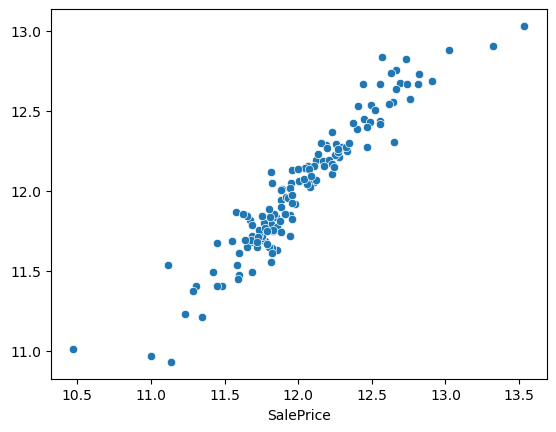

In [103]:
sns.scatterplot(x=y_test, y=y_pred_test)
plt.show()